In [1]:
from glob import glob
from os.path import exists, join, basename
from tqdm import tqdm
from json import load, dump
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from quadtreed3 import Quadtree, Node
from scipy.sparse import csr_matrix
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from typing import Tuple

import re
import os
import shutil
import random
#import cuml
import pickle
import torch
import ndjson

import pandas as pd
import numpy as np

SEED = 20220101

# plt.style.use('ggplot')
# plt.rcParams['figure.dpi'] = 300

In [2]:
# LOCAL
%run "conf/setup.ipynb"
# KAGGLE
#%run /kaggle/usr/lib/setup/setup.py
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
# %matplotlib widget # For interactive plots
# plt.ioff()

## Load the Complete Paper Collection

In [3]:
## KAGGLE
# data = pd.read_csv('/kaggle/input/cleaned_df/cleaned_df.csv').set_index('System ID')
data = pd.read_csv('data/cleaned_df.csv').set_index('System ID')

data['Publication Date'] = pd.to_datetime(data['Publication Date'])
# Fix missing values coding in the data_origin column
data['Data_origin'] = data['Data_origin'].replace('N.A.', pd.NA)
data.sort_values(by='Lenght_Abs', inplace=True)

data.info()
print()
print("# of unique PMCID values:", data['PMCID'].nunique())
print("# of unique PMID values:", data['PMID'].nunique())
print("# of unique DOI values:", data['DOI'].nunique())
print("# of unique Title values:", data['Title'].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 2476 entries, 10.1101/2021.06.06.21258428 to 33928254
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DOI                       2131 non-null   object        
 1   Latest Version            2476 non-null   object        
 2   PMCID                     1712 non-null   object        
 3   PMID                      1882 non-null   float64       
 4   Pub Year                  2476 non-null   int64         
 5   Publication Date          2476 non-null   datetime64[ns]
 6   Publication Types         2476 non-null   object        
 7   Source                    2476 non-null   object        
 8   Peer_Review               2476 non-null   int64         
 9   Title                     2476 non-null   object        
 10  Cleaned_Abs               2476 non-null   object        
 11  Lenght_Abs                2476 non-null   int64         


In [4]:
# Concatenate the modified "Task_(primary)" column with "Modality" column using the string ' with '
data['Task_Modality'] = (data['Task_(primary)'].str.replace(r'^\d+\.\s*', '') +
                         ' with ' +
                         data['Modality'])

# Remove numeric prefixes from 'Task_(primary)' column
data['Task_(primary)'] = data['Task_(primary)'].str.split('.').str[-1].str.strip()

# Select rows where "Task_(primary)" is equal to 'Review' and replace 'with' with 'on' in "Task_Modality" column
data.loc[data['Task_(primary)'] == 'Review', 'Task_Modality'] = data[data['Task_(primary)'] == 'Review']['Task_Modality'].str.replace('with', 'on', case=False)

# Concatenate Title and Abstract as it is usually done with these texts
data.insert(12, 'Title_Abstract', data['Title'] + ' [SEP] ' + data['Cleaned_Abs'])

# Initialize the 'Reference' column as a string
data['Reference'] = ''

for i, row in data.iterrows():
    data.at[i, 'Reference'] = str(row['Journal Name']) if pd.notnull(row['Journal Name']) else str(row['Source'])
    if pd.isnull(row['DOI']):  # Check if 'DOI' is missing
        if pd.notnull(row['PMCID']):  
            # If 'PMCID' is present, add it to the 'Reference'
            data.at[i, 'Reference'] += ' - ' + 'PMCID: ' + row['PMCID']
        elif pd.notnull(row['PMID']):  
            # If 'PMCID' is missing but 'PMID' is present, add 'PMID' to the 'Reference'
            data.at[i, 'Reference'] += ' - ' + 'PMID: ' + str(row['PMID'])
        else:  
            # If both 'PMCID' and 'PMID' are missing, concatenate with the 'Publication Date'
            data.at[i, 'Reference'] += ', ' + str(row['Publication Date']).split()[0]
    else:  
        # If 'DOI' is present, add it to the 'Reference'
        data.at[i, 'Reference'] += ' - ' + 'DOI: ' + row['DOI']

data['Reference']

/var/folders/w5/bq4n328s7yq69d4k2_9zsl480000gn/T/ipykernel_8862/3189382636.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



System ID
10.1101/2021.06.06.21258428           medRxiv - DOI: 10.1101/2021.06.06.21258428
34042629                       Stud Health Technol Inform - DOI: 10.3233/SHTI...
32804639                            IEEE Pulse - DOI: 10.1109/MPULS.2020.3008354
33623737                       J Microsc Ultrastruct - DOI: 10.4103/JMAU.JMAU...
10.1101/2021.01.10.21249370           medRxiv - DOI: 10.1101/2021.01.10.21249370
                                                     ...                        
34048371                       Crit Care Med - DOI: 10.1097/CCM.0000000000005172
34519581                              Radiology - DOI: 10.1148/radiol.2021212212
33350895                              Radiology - DOI: 10.1148/radiol.2020204226
34240059                       Radiol Artif Intell - DOI: 10.1148/ryai.202121...
33928254                       Radiol Artif Intell - DOI: 10.1148/ryai.202020...
Name: Reference, Length: 2476, dtype: object

## Extract Abstract Embedding 

In [5]:
# Check if CUDA is available, and assign the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model_ckpt = 'allenai/specter2_aug2023refresh_base'

if device == 'cuda':
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)
    # Manually setting model_max_length as it may default to VERY_LARGE_INTEGER (int(1e30)) 
    tokenizer.init_kwargs
    # Instantiate SPECTER
    model = AutoModel.from_pretrained(model_ckpt).to(device)
    print("running on device: {}".format(device))

In [7]:
%%time
#%memit

n_rows = len(data)

if device == 'cuda':
    hidden_size = model.pooler.dense.in_features
    # Extracting CLS embeddings only among those returned by the generate_embeddings custom function
    embeddings = np.zeros([n_rows, hidden_size]) 
    for i, abst in enumerate(dataset['Title_Abstract']): 
        embeddings[i], _, _ = generate_embeddings(abst, tokenizer, model, device)

    # Get Model Name
    model_name = model_ckpt.split("/")[-1]

    # Optionally save individual arrays to Numpy standard binary format .npy
    #np.save(model_name + '_CLS_embed', embeddings)

    # Create new columns in the pandas DataFrame and assign the embeddings
    data['SPECTER_embed'] = embeddings.tolist()

    # Save results in a binary format
    data['SPECTER_embed'].to_pickle('embeddings.pkl')
    data.to_pickle('encoded_df.pkl')
else:
    data['SPECTER_embed'] = pd.read_pickle('data/embeddings.pkl')
    data.to_pickle('data/encoded_df.pkl')

CPU times: user 57.9 ms, sys: 20.4 ms, total: 78.3 ms
Wall time: 84 ms


## Create UMAP from Embeddings

In [8]:
data = pd.read_pickle('data/encoded_df.pkl')
data.head()

DOI Latest Version  \
System ID                                                                 
10.1101/2021.06.06.21258428  10.1101/2021.06.06.21258428            Yes   
34042629                              10.3233/SHTI210223            Yes   
32804639                      10.1109/MPULS.2020.3008354            Yes   
33623737                         10.4103/JMAU.JMAU_28_20            Yes   
10.1101/2021.01.10.21249370  10.1101/2021.01.10.21249370            Yes   

                                  PMCID        PMID  Pub Year  \
System ID                                                       
10.1101/2021.06.06.21258428         NaN         NaN      2021   
34042629                            NaN  34042629.0      2021   
32804639                            NaN  32804639.0      2020   
33623737                     PMC7883503  33623737.0      2021   
10.1101/2021.01.10.21249370         NaN         NaN      2021   

                            Publication Date       Publication Types  \
System ID                                                              
10.1101/2021.06.06.21258428       2021-06-09                Preprint   
34042629                          2021-05-28         Journal Article   
32804639                          2020-08-18         Journal Article   
33623737                          2021-02-25  Journal Article;Review   
10.1101/2021.01.10.21249370       2021-01-15                Preprint   

                                             Source  Peer_Review  \
System ID                                                          
10.1101/2021.06.06.21258428                 medRxiv            0   
34042629                     Peer reviewed (PubMed)            1   
32804639                     Peer reviewed (PubMed)            1   
33623737                     Peer reviewed (PubMed)            1   
10.1101/2021.01.10.21249370                 medRxiv            0   

                                                                         Title  \
System ID                                                                        
10.1101/2021.06.06.21258428  g-cxr-net: a graphic application for the rapid...   
34042629                     covid-19 image segmentation based on deep lear...   
32804639                     ai-driven covid-19 tools to interpret quantify...   
33623737                     artificial intelligence in covid-19 ultrastruc...   
10.1101/2021.01.10.21249370  dynamic prediction of sars-cov-2 rt-pcr status...   

                             ... popularity_alt_score  popularity_score  \
System ID                    ...                                          
10.1101/2021.06.06.21258428  ...                  NaN               NaN   
34042629                     ...               47.080          0.000003   
32804639                     ...               49.752          0.000003   
33623737                     ...               12.720          0.000001   
10.1101/2021.01.10.21249370  ...                  NaN               NaN   

                            influence_alt_score tweets_count  Data_origin  \
System ID                                                                   
10.1101/2021.06.06.21258428                 NaN          NaN          NaN   
34042629                                  111.0          0.0          NaN   
32804639                                  185.0          0.0          NaN   
33623737                                   46.0          0.0          NaN   
10.1101/2021.01.10.21249370                 NaN          NaN          NaN   

                            Task_(primary)    Modality         Task_Modality  \
System ID                                                                      
10.1101/2021.06.06.21258428            NaN         NaN                   NaN   
34042629                               NaN         NaN                   NaN   
32804639                            Review  Multimodal  Review on Multimodal   
33623737                               NaN      

The `n_neighbors` parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of `n_neighbors` will force UMAP to **concentrate on very local structure** (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure **for the sake of getting the broader of the data**.

The ``min_dist`` parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of ``min_dist`` will result in clumpier embeddings. This can be useful if you are interested in clustering, or in finer topological structure. Larger values of ``min_dist`` will prevent UMAP from packing points together and will focus on the preservation of the broad topological structure instead. The default value for ``min_dist`` is 0.1. 

In [9]:
#%pip install umap-learn
import umap, umap.plot
# Instantiate
reducer = umap.UMAP(n_neighbors=100, metric='cosine', min_dist=0)
# Fit UMAP
embedding = reducer.fit(data['SPECTER_embed'].tolist())
projected_emb = reducer.fit_transform(data['SPECTER_embed'].tolist())


/Users/giovanni/anaconda3/envs/nlp_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/Users/giovanni/anaconda3/envs/nlp_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/Users/giovanni/anaconda3/envs/nlp_env/lib/python3.11/site-packages/umap/distances.py:10

In [10]:
projected_emb.shape
print(type(embedding))
print(type(projected_emb))

<class 'umap.umap_.UMAP'>
<class 'numpy.ndarray'>


In [11]:
# Data: x, y, abstract, title, year
umap_df = pd.DataFrame({
    'xs': projected_emb[:, 0],
    'ys': projected_emb[:, 1],
    'abstracts': list(data['Cleaned_Abs']),
    'titles': list(data['Title']),
    'years': list(map(lambda x: int(x), data['Pub Year'])),
    'reference': list(data['Reference'])
})

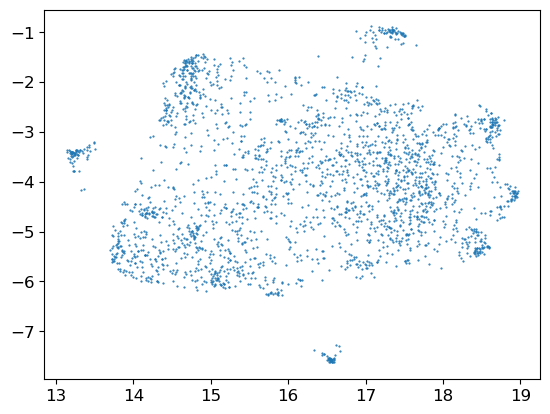

In [15]:
#plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
plt.scatter(projected_emb[:, 0], projected_emb[:, 1], s=0.3, alpha=1)

As ``n_neighbors`` is increased UMAP manages to see more of the overall structure of the data, gluing more components together, and better coverying the broader structure of the data.

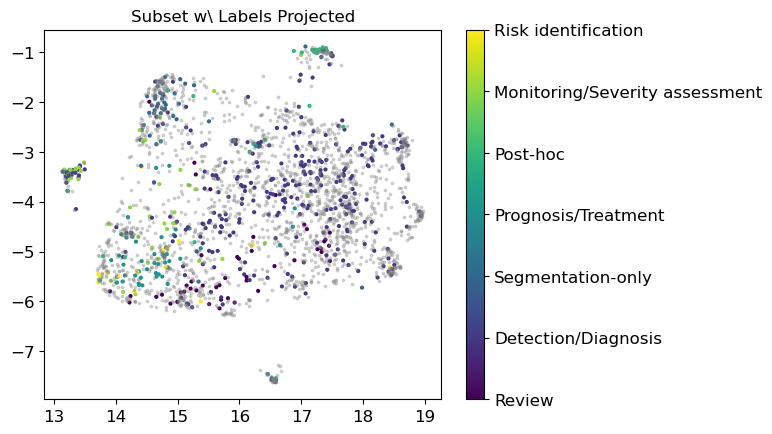

In [16]:
labels_idx = pd.notnull(data['Modality'])
unlabel_idx = pd.isnull(data['Modality'])
# Convert categorical data to numerical data
labels, _ = pd.factorize(data[labels_idx]['Task_(primary)'])
# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: pd.unique(data[labels_idx]['Task_(primary)'].values)[int(i)])

# Create scatter plot
plt.clf()
plt.title('Subset w\ Labels Projected')
plt.scatter(projected_emb[labels_idx, 0], projected_emb[labels_idx, 1], s=4, alpha=1, c=labels)
plt.colorbar(ticks=range(len(np.unique(labels))), format=formatter)
plt.scatter(projected_emb[unlabel_idx, 0], projected_emb[unlabel_idx, 1], s=3, alpha=0.3, c='grey')

Now we can make an interactive plot using `umap.plot.interactive`. This has a very similar API to the `umap.plot.points` approach, but also supports a `hover_data` keyword which, if passed a suitable dataframe, will provide hover tooltips in the interactive plot.
For interactive use the `umap.plot` package makes use of bokeh. Bokeh has several output methods, but in the following we’ll be outputting in a browser window. Using the `output_notebook` function it will output inline in a notebook .

In [14]:
labels, _ = pd.factorize(data['Task_(primary)'])
hover_df = pd.DataFrame(data, columns=['DOI', 'Title', 'Task_Modality']).reset_index()
#f = umap.plot.points(embedding, labels=labels, point_size=2)
# umap.plot.output_notebook()
f = umap.plot.interactive(embedding, hover_data=hover_df, labels=labels, point_size=3)
umap.plot.show(f)


In [ ]:
umap_df.to_csv(join('data/UMAP.csv'), index=False)
umap_df.info()

## Setting-up Tensorflow Embedding Projector

## Create KDE


In [ ]:
cur_df = pd.read_csv('data/umap.csv')

In [ ]:
xs = cur_df['xs'].to_numpy()
ys = cur_df['ys'].to_numpy()

projected_emb = np.stack((xs, ys), axis=1)

In [ ]:
xs = projected_emb[:, 0]
ys = projected_emb[:, 1]

x_min, x_max = np.min(xs), np.max(xs)
y_min, y_max = np.min(ys), np.max(ys)

x_gap = x_max - x_min
y_gap = y_max - y_min

if x_gap > y_gap:
    # Expand the larger range to leave some padding in the plots
    x_min -= x_gap / 50
    x_max += x_gap / 50
    x_gap = x_max - x_min
    
    # Regulate the 2D grid to be a square
    y_min -= (x_gap - y_gap) / 2
    y_max += (x_gap - y_gap) / 2
else:
    # Expand the larger range to leave some padding in the plots
    y_min -= y_gap / 50
    y_max += y_gap / 50
    y_gap = y_max - y_min
    
    # Regulate the 2D grid to be a square
    x_min -= (y_gap - x_gap) / 2
    x_max += (y_gap - x_gap) / 2

# Estimate on a 2D grid
grid_size = 200
grid_xs = np.linspace(x_min, x_max, grid_size)
grid_ys = np.linspace(y_min, y_max, grid_size)
xx, yy = np.meshgrid(grid_xs, grid_ys)

grid = np.vstack([xx.ravel(), yy.ravel()]).transpose()
print(x_min, y_min, x_max, y_max)

In [ ]:
# # Compute the bandwidth using silverman's rule
sample_size = 100000
n = sample_size
d = projected_emb.shape[1]
bw = (n * (d + 2) / 4.)**(-1. / (d + 4))

# We use a random sample to fit the KDE for faster run time
rng = np.random.RandomState(SEED)
random_indexes = rng.choice(range(projected_emb.shape[0]),
                            min(projected_emb.shape[0], sample_size),
                            replace=False)

kde = KernelDensity(kernel='gaussian', bandwidth=bw)
kde.fit(projected_emb[random_indexes, :])

In [ ]:
# Sklearn
log_density = kde.score_samples(grid)
log_density = np.exp(log_density)
grid_density = np.reshape(log_density, xx.shape)
grid_density.shape

In [ ]:
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Contourf plot
ax.set_title(f'KDE on {grid_density.shape[0]} Grid of {sample_size} Samples (bw={bw:.2f})')
cfset = ax.contourf(xx, yy, grid_density.round(4),
                    levels=np.linspace(0, np.max(grid_density), 20),
                    cmap='Blues',
                    alpha=1)


## Create KDE for Each Year

In [ ]:
# Create a histogram using Seaborn
#plt.figure(figsize=(10, 6))
plt.figure(figsize=(11, 5))
sns.histplot(data=data, x='Publication Date', bins=30, kde=True, color='blue')

# add plot labels and legend
plt.xlabel('Publication Date', labelpad=15, fontsize=14)
plt.ylabel('# of Papers Published', labelpad=15, fontsize=14)
#plt.title('Distribution of Papers Published between 2020-01 and 2023-05', fontsize=15, fontweight='bold')
plt.grid(alpha=0.4)

# Reduce the size of xticks
plt.xticks(fontsize=11)

# Show the plot
#save_fig('Publishing_Dates_Histogram', fig_extension="png")
plt.show()

# Reset rcParams to default values
plt.rcdefaults()

In [ ]:
time_grids = {}
for cur_year in tqdm(range(1980, 2022)):
    cur_kde = KernelDensity(kernel='gaussian', bandwidth=bw)

    cur_indexes = np.where(umap_df['years'] == cur_year)[0]
    cur_kde.fit(projected_emb[cur_indexes, :])

    # Compute KDE and transform it to likelihood scale
    cur_log_density = cur_kde.score_samples(grid)
    cur_density = np.exp(cur_log_density)
    cur_grid_density = np.reshape(cur_density, xx.shape)
    cur_grid = cur_grid_density.astype(float).round(4).tolist()

    # Record this year's grid
    time_grids[str(cur_year)] = cur_grid

In [ ]:
x_min, x_max, y_min, y_max = float(x_min), float(x_max), float(y_min), float(y_max)

grid_density_json = {
    'grid': grid_density.astype(float).round(4).tolist(),
    'xRange': [x_min, x_max],
    'yRange': [y_min, y_max],
    'sampleSize': sample_size,
    'totalPointSize': umap_df.shape[0],
    'padded': True,
    'timeGrids': time_grids
}

dump(grid_density_json, open(join(DATA_DIR, 'umap-grid.json'), 'w'))

## Pre-compute Embedding Summaries

In [ ]:
umap_df = pd.read_csv(join(DATA_DIR, 'umap.csv'))

data = []
texts = []

text_key = 'abstracts'
texts = umap_df[text_key]

xs = umap_df['xs']
ys = umap_df['ys']

# Create data array
for i in range(len(xs)):
    cur_data = {
        'x': xs[i],
        'y': ys[i],
        'pid': i,
    }
    data.append(cur_data)

In [ ]:
def top_n_idx_sparse(matrix: csr_matrix, n: int) -> np.ndarray:
    """ Return indices of top n values in each row of a sparse matrix
    Retrieved from:
        https://github.com/MaartenGr/BERTopic/blob/master/bertopic/_bertopic.py#L2801
    Arguments:
        matrix: The sparse matrix from which to get the top n indices per row
        n: The number of highest values to extract from each row
    Returns:
        indices: The top n indices per row
    """
    indices = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        values = matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]]
        values = [values[index] if len(values) >= index + 1 else None for index in range(n)]
        indices.append(values)
    return np.array(indices)


def top_n_values_sparse(matrix: csr_matrix, indices: np.ndarray) -> np.ndarray:
    """ Return the top n values for each row in a sparse matrix
    Arguments:
        matrix: The sparse matrix from which to get the top n indices per row
        indices: The top n indices per row
    Returns:
        top_values: The top n scores per row
    """
    top_values = []
    for row in range(indices.shape[0]):
        scores = np.array([matrix[row, c] if c is not None else 0 for c in indices[row, :]])
        top_values.append(scores)
    return np.array(top_values)

def merge_leaves_before_level(root: Node, target_level: int) -> Tuple[list, list, dict]:
    """
    Merge all nodes to their parents until the tree is target_level tall (modify
    root in-place) and extract all data from leaf nodes before or at the target_level.

    Args:
        root (Node): Root node
        target_level (int): Target level

    Returns:
        csr_row_indexes (list): Row indexes for the sparse matrix. Each row is
            a leaf node.
        csr_column_indexes (list): Column indexes for the sparse matrix. Each column
            is a prompt ID.
        row_node_map (dict): A dictionary map row index to the leaf node.
    """
    
    x0, y0, x1, y1 = root.position
    step_size = (x1 - x0) / (2 ** target_level)

    # Find all leaves at or before the target level
    row_pos_map = {}
    stack = [root]

    # We create a sparse matrix by (data, (row index, column index))
    csr_row_indexes, csr_column_indexes = [], []

    # In the multiplication sparse matrix, each row represents a tile / collection,
    # and each column represents a prompt ID
    cur_r = 0

    while len(stack) > 0:
        cur_node = stack.pop()
        
        if cur_node.level >= target_level:        
            # A new traverse here to concatenate all the prompts from its subtree,
            # and to merge it with its children
            local_stack = [cur_node]
            subtree_data = []

            while len(local_stack) > 0:
                local_node = local_stack.pop()
                
                if len(local_node.children) == 0:
                    # Leaf node
                    subtree_data.extend(local_node.data)
                else:
                    for c in local_node.children[::-1]:
                        if c is not None:
                            local_stack.append(c)
                            
            # Detach all the children and get their data
            cur_node.children = []
            cur_node.data = subtree_data
            
            # Register this node in a dictionary for faster access
            row_pos_map[cur_r] =  list(map(lambda x: round(x, 3), cur_node.position))
            
            # Collect the prompt IDs
            for d in cur_node.data:
                csr_row_indexes.append(cur_r)
                csr_column_indexes.append(d['pid'])
                
            # Move on to the next tile / collection
            cur_r += 1

        else:
            if len(cur_node.children) == 0:
                # Leaf node => it means this leaf is before the target level
                # We need to adjust the node's position so that it has the same
                # size as leaf nodes at the target_level
                x, y = cur_node.data[0]['x'], cur_node.data[0]['y']
                xi, yi = int((x - x0) // step_size), int((y - y0) // step_size)

                # Find the bounding box of current level of this leaf node
                xi0, yi0 = x0 + xi * step_size, y0 + yi * step_size
                xi1, yi1 = xi0 + step_size, yi0 + step_size
                row_pos_map[cur_r] = list(map(lambda x: round(x, 3), [xi0, yi0, xi1, yi1]))
                
                # Collect the prompt IDs
                for d in cur_node.data:
                    csr_row_indexes.append(cur_r)
                    csr_column_indexes.append(d['pid'])
                
                # Move on to the next tile / collection
                cur_r += 1

            else:
                for c in cur_node.children[::-1]:
                    if c is not None:
                        stack.append((c))
    
    return csr_row_indexes, csr_column_indexes, row_pos_map


def get_tile_topics(count_mat, row_pos_map, ngrams, top_k=10):
    """Get the top-k important keywords from all rows in the count_mat.

    Args:
        count_mat (csr_mat): A count matrix
        row_pos_map (dict): A dictionary that maps row index to the corresponding
            leaf node's location in the quadtree
        ngrams (list[str]): Feature names in the count_mat
        top_k (int): Number of keywords to extract
    """
    
    
    # Compute tf-idf score
    t_tf_idf_model = TfidfTransformer()
    t_tf_idf = t_tf_idf_model.fit_transform(count_mat)
    
    # Get words with top scores for each tile
    indices = top_n_idx_sparse(t_tf_idf, top_k)
    scores = top_n_values_sparse(t_tf_idf, indices)

    sorted_indices = np.argsort(scores, 1)
    indices = np.take_along_axis(indices, sorted_indices, axis=1)
    scores = np.take_along_axis(scores, sorted_indices, axis=1)
    
    # Store these keywords
    tile_topics = []

    for r in row_pos_map:
        word_scores = [
            (ngrams[word_index], round(score, 4))
            if word_index is not None and score > 0
            else ("", 0.00001)
            for word_index, score in zip(indices[r][::-1], scores[r][::-1])
        ]

        tile_topics.append({
            'w': word_scores,
            'p': row_pos_map[r]
        })

    return tile_topics

def extract_level_topics(
    root: Node,
    count_mat: csr_matrix,
    texts: list[str],
    ngrams: list[str],
    min_level = None,
    max_level = None
):
    """Extract topics for all leaf nodes at all levels of the quadtree.

    Args:
        root (Noe): Quadtree node
        count_mat (csr_matrix): Count vector for the corpus
        texts (list[str]): A list of all the embeddings' texts
        ngrams (list[str]): n-gram list for the count vectorizer
    """

    level_tile_topics = {}
    
    if min_level is None:
        min_level = 0

    if max_level is None:
        max_level = root.height

    for level in tqdm(list(range(max_level, min_level - 1, -1))):
        # Create a sparse matrix
        csr_row_indexes, csr_column_indexes, row_node_map = merge_leaves_before_level(
            root, level
        )

        csr_data = [1 for _ in range(len(csr_row_indexes))]
        tile_mat = csr_matrix(
            (csr_data, (csr_row_indexes, csr_column_indexes)),
            shape=(len(texts), len(texts)),
        )

        # Transform the count matrix
        new_count_mat = tile_mat @ count_mat

        # Compute t-tf-idf scores and extract keywords
        tile_topics = get_tile_topics(new_count_mat, row_node_map, ngrams)
        
        level_tile_topics[level] = tile_topics
        
    return level_tile_topics


def select_topic_levels(
    max_zoom_scale,
    svg_width,
    svg_height,
    x_domain,
    y_domain,
    tree_extent,
    ideal_tile_width=35,
):
    """
    Automatically determine the min and max topic levels needed for the visualization.

    Args:
        max_zoom_scale (float): Max zoom scale level
        svg_width (int): SVG width
        svg_height (int): SVG height
        x_domain ([float, float]): [x min, x max]
        y_domain ([float, float]): [y min, y max]
        tree_extent ([[float, float], [float, float]]): The extent of the tree
        ideal_tile_width (int, optional): Optimal tile width in pixel. Defaults to 35.
    """

    svg_length = max(svg_width, svg_height)
    world_length = max(x_domain[1] - x_domain[0], y_domain[1] - y_domain[0])
    tree_to_world_scale = (tree_extent[1][0] - tree_extent[0][0]) / world_length

    scale = 1
    selected_levels = []

    while scale <= max_zoom_scale:
        best_level = 1
        best_tile_width_diff = np.Infinity

        for l in range(1, 21):
            tile_num = 2**l
            svg_scaled_length = scale * svg_length * tree_to_world_scale
            tile_width = svg_scaled_length / tile_num

            if abs(tile_width - ideal_tile_width) < best_tile_width_diff:
                best_tile_width_diff = abs(tile_width - ideal_tile_width)
                best_level = l

        selected_levels.append(best_level)
        scale += 0.5

    return np.min(selected_levels), np.max(selected_levels)


In [ ]:
# Build the quadtree
tree = Quadtree()
tree.add_all_data(data)

# Build the count matrix
root = tree.get_node_representation()

cv = CountVectorizer(stop_words="english", ngram_range=(1, 1))
count_mat = cv.fit_transform(texts)
ngrams = cv.get_feature_names_out()

In [ ]:
max_zoom_scale = 20
svg_width = 800
svg_height = 800
xs = [d['x'] for d in data]
ys = [d['y'] for d in data]
x_domain = [np.min(xs), np.max(xs)]
y_domain = [np.min(ys), np.max(ys)]

# Get suggestions of quadtree levels to extract
min_level, max_level = select_topic_levels(
    max_zoom_scale, svg_width, svg_height, x_domain, y_domain, tree.extent()
)
print(min_level, max_level)

In [ ]:
level_tile_topics = extract_level_topics(
    root, count_mat, texts, ngrams, min_level=min_level, max_level=max_level
)

In [ ]:
data_dict = {
    'extent': tree.extent(),
    'data': {},
    'range': [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
}

for cur_level in range(min_level, max_level + 1):
    cur_topics = level_tile_topics[cur_level]
    data_dict['data'][cur_level] = []

    for topic in cur_topics:
        # Get the topic name
        name = '-'.join([p[0] for p in topic['w'][:4]])
        x = (topic['p'][0] + topic['p'][2]) / 2
        y = (topic['p'][1] + topic['p'][3]) / 2
        cur_data = {
            'x': round(x, 3),
            'y': round(y, 3),
            'n': name,
            'l': cur_level
        }
        data_dict['data'][cur_level].append(
            [round(x, 3), round(y, 3), name]
        )

In [ ]:
dump(data_dict, open(join(DATA_DIR, 'topic-data.json'), 'w'))

## Export NDJSON

In [ ]:
umap_df = pd.read_csv(join(DATA_DIR, 'umap.csv'))

text_key = 'abstracts'
time_key = 'years'
label_key = 'titles'

texts = umap_df[text_key]

if time_key is not None:
    times = list(map(str, umap_df[time_key]))
else:
    times = []
    
if label_key is not None:
    labels = umap_df[label_key]
else:
    labels = []

xs = umap_df['xs']
ys = umap_df['ys']

umap_data_short = []

for i in range(len(xs)):
    cur_row = [xs[i], ys[i], texts[i]]
    
    if time_key is not None:
        cur_row.append(times[i])
        
        if label_key is not None:
            cur_row.append(labels[i])
    
    else:
        if label_key is not None:
            cur_row.append('')
            cur_row.append(labels[i])

    umap_data_short.append(cur_row)
    
with open(join(DATA_DIR, "./umap.ndjson"), 'w') as fp:
    ndjson.dump(umap_data_short, fp)